In [1]:
# Fruit Classification
#This notebook demonstrates image classification on a fruit dataset using TensorFlow/Keras and TensorFlow Lite for inference.  
#contact me at: jedatarachid@gmail.com


In [1]:
!curl https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

^C


In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [3]:
img_height, img_width = 64, 64
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle=False
)

Found 460 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 130 files belonging to 3 classes.


(20, 64, 64, 3)


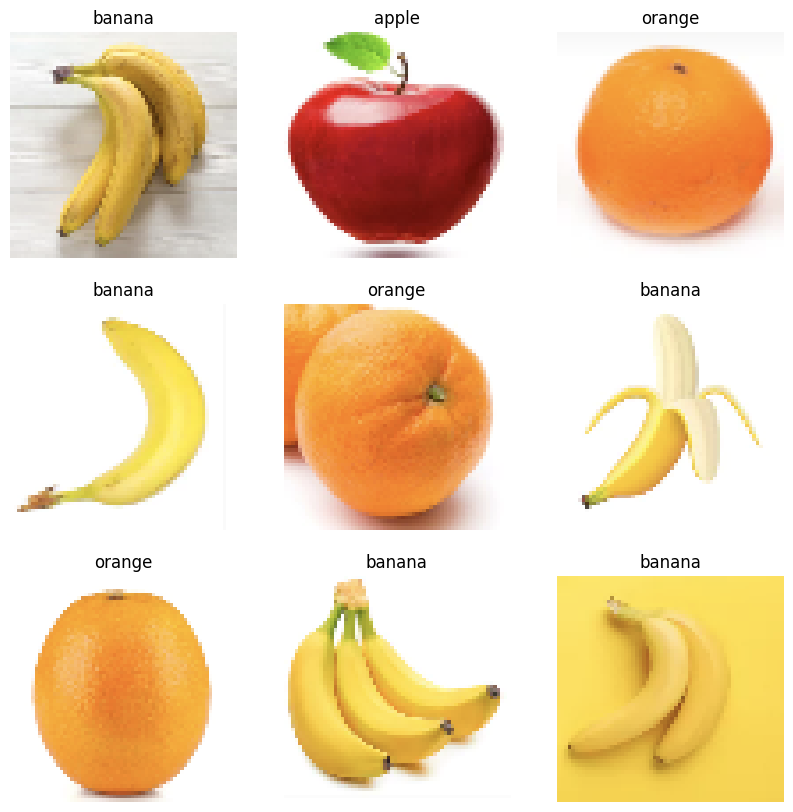

In [4]:
class_names = ["apple", "banana", "orange"]
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  print(images.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [ ]:
model = tf.keras.Sequential(
    [
     #cnn
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),

     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
     tf.keras.layers.Dropout(0.5),  # Drop 50% of neurons randomly
     tf.keras.layers.Dense(3),
     tf.keras.layers.Softmax()
    ]
)


In [26]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,  # stop after 2 epochs when no improvement
    restore_best_weights=True
)


In [ ]:
model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    epochs = 20,
    callbacks=[early_stopping],
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9848 - loss: 0.1153 - val_accuracy: 0.9545 - val_loss: 0.2146
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9848 - loss: 0.1026 - val_accuracy: 0.9697 - val_loss: 0.1766


In [38]:
model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9615 - loss: 0.2009


[0.20085780322551727, 0.9615384340286255]

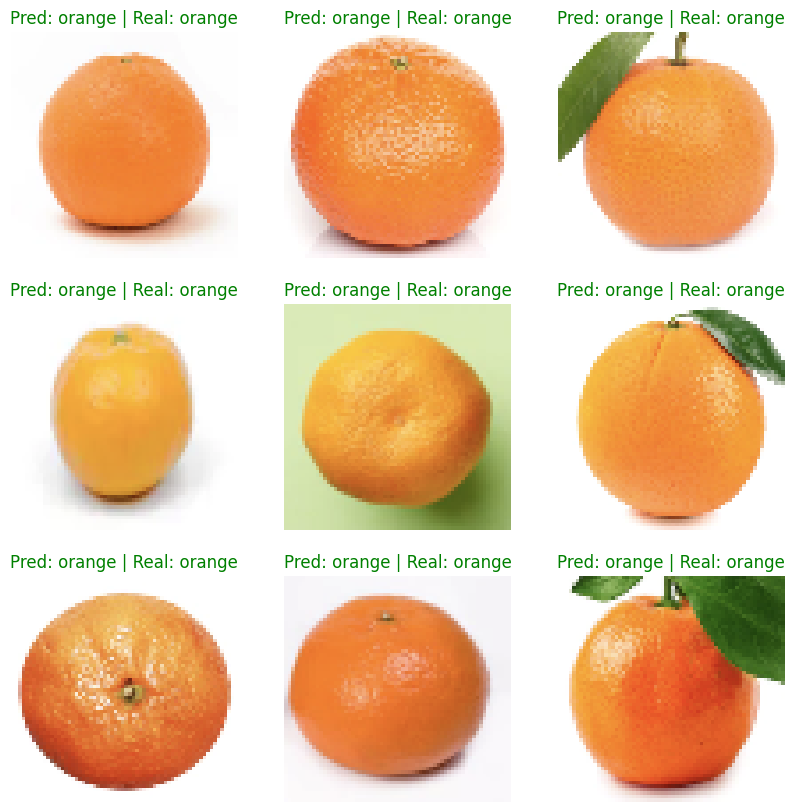

In [39]:
plt.figure(figsize=(10,10))
for images, labels in test_ds:
  classifications = model(images)
  # print(classifications)
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(classifications[i])
    color = "red" if index != labels[i] else "green"
    plt.title(f"Pred: {class_names[index]} | Real: {class_names[labels[i]]}", color=color)
    plt.axis("off")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


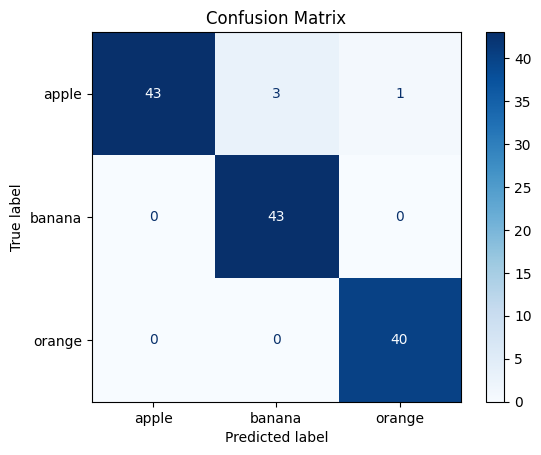

In [12]:
# Get predictions
y_pred = model.predict(test_ds)

# Convert probabilities → class indices
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



In [42]:
print(classification_report(y_true, y_pred_classes, target_names=test_ds.class_names))

              precision    recall  f1-score   support

       apple       1.00      0.91      0.96        47
      banana       0.93      1.00      0.97        43
      orange       0.98      1.00      0.99        40

    accuracy                           0.97       130
   macro avg       0.97      0.97      0.97       130
weighted avg       0.97      0.97      0.97       130



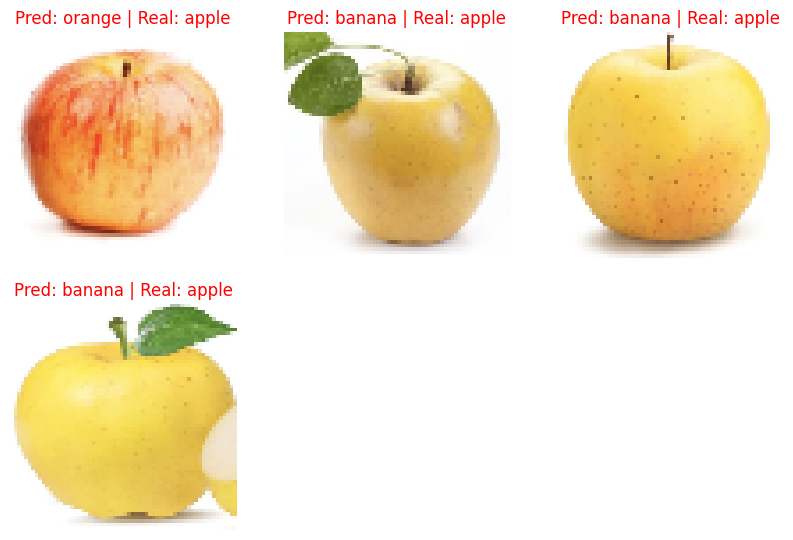

In [13]:
plt.figure(figsize=(10, 10))

wrong_images = []
wrong_preds = []
wrong_labels = []

# Loop through the dataset and collect wrong predictions
for images, labels in test_ds:
    classifications = model(images)
    preds = tf.argmax(classifications, axis=1,output_type=tf.int32)

    # Find wrong predictions
    for i in range(len(labels)):
        if preds[i] != labels[i]:
            wrong_images.append(images[i])
            wrong_preds.append(preds[i])
            wrong_labels.append(labels[i])

# Show the first 9 wrong predictions
for i in range(min(9, len(wrong_images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(wrong_images[i].numpy().astype("uint8"))
    plt.title(
        f"Pred: {class_names[wrong_preds[i]]} | Real: {class_names[wrong_labels[i]]}",
        color="red"
    )
    plt.axis("off")

plt.show()


In [14]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\dell\AppData\Local\Temp\tmp5afc7oib\assets


INFO:tensorflow:Assets written to: C:\Users\dell\AppData\Local\Temp\tmp5afc7oib\assets


Saved artifact at 'C:\Users\dell\AppData\Local\Temp\tmp5afc7oib'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1501743545424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501743545040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501743545232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501743330320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501742680208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501743774416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501743770384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501743771728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501743774224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1501746414032: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [15]:
# Take one batch from the dataset
for images, labels in train_ds.take(1):
    sample_image = images[0].numpy()                 # shape: (64, 64, 3)
    input_data = np.expand_dims(sample_image, axis=0)  # shape: (1, 64, 64, 3)
    real_class_index = labels[0].numpy()        # get integer label
    real_class_name = class_names[real_class_index]  # convert to string

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


# Set the tensor
#index = the address of the box inside TFLite memory
#index → mandatory to tell TFLite where to put your input
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get prediction
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

print("Predicted class:", class_names[predicted_class], "\nReal Class:", real_class_name)


Predicted class: banana 
Real Class: banana


c:\Users\dell\Desktop\ISIC\DeepLearning\Lab_DeepLearning\jedata_venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
